# Make sure ComBind Score is calibrated

In [1]:
import sys
sys.path.append('../3_analyze')
from density_estimate import DensityEstimate

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = {}
with open('../../combind_data/bpp_outputs/fps.csv') as fp:
    fp.readline()
    for line in fp:
        try:
            (protein, struct, ligand, rank, gscore, emodel,
             rmsd, finger) = line.strip().split('\t')
            if protein not in data: data[protein] = {}
            if ligand not in data[protein]: data[protein][ligand] = {}
            finger = {(int(interaction), residue): float(score)
                      for interaction, residue, score in \
                      map(lambda x: x.split(','), finger.split(';'))}
            gscore, emodel, rmsd = float(gscore), float(emodel), float(rmsd)
            rank = int(rank)
            data[protein][ligand][rank] = (gscore, emodel, rmsd, finger)
        except:
            pass
for protein, ligand in data.items():
    print protein, len(ligand)

P00489 20
5HT2B 2
PLK1 12
Q16539 19
MGLUR5 5
ERA 19
M3 2
P07900 20
GLUT1 3
P18031 20
P56817 20
O60885 17
MEK1 20
JAK2 20
P00742 20
DTRANSP 9
SIGMA1 2
P00734 20
P00760 20
B2AR 8
GCR 18
P24941 13
B1AR 12
VITD 20
A2AR 18
SMO 7
P03951 14
P00749 20
Q9Y233 20
CHK1 20
TRPV1 2
CDK2 20
AR 11
BRAF 19
MR 13
STRANSP 5


In [5]:
features = {
    'hbond_donor':[2],
    'hbond_acceptor':[3],
    #'sb1':[0],
    'sb2':[1],
    #'sb3':[4],
    'pipi':[6],
    'picat':[7,8],
    'contact':[11]
}

max_poses = 100

# P(Native | Glide Score)

- Fits theoretical distribution $\frac{1}{1+e^{G+C}}$

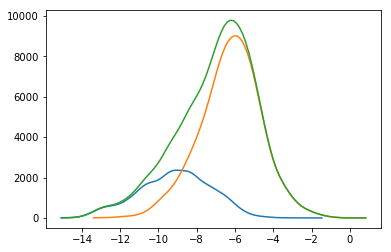

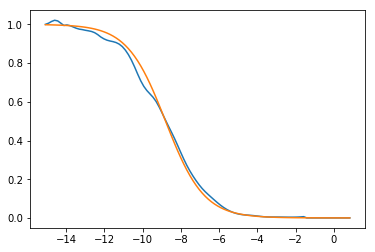

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log


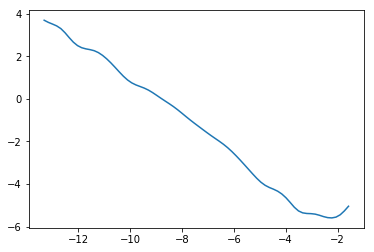

In [153]:
gscores = np.array([pose[0]
                    for protein, ligands in data.items()
                    for ligand, poses in ligands.items()
                    for rank, pose in poses.items()
                    if rank < max_poses])
natives = np.array([pose[2] <= 2
                    for protein, ligands in data.items()
                    for ligand, poses in ligands.items()
                    for rank, pose in poses.items()
                    if rank < max_poses])

native_gscore = DensityEstimate(points=100, reflect=False, sd = 0.4, out_of_bounds=0).fit(gscores[natives==1])
decoy_gscore = DensityEstimate(points=100, reflect=False, sd = 0.4, out_of_bounds=0).fit(gscores[natives==0])
reference_gscore = DensityEstimate(points=100, reflect=False, sd = 0.4, out_of_bounds=0).fit(gscores)

plt.plot(native_gscore.x, native_gscore.fx*native_gscore.n_samples)
plt.plot(decoy_gscore.x, decoy_gscore.fx*decoy_gscore.n_samples)
plt.plot(reference_gscore.x, reference_gscore.fx*reference_gscore.n_samples)
plt.show()

pnative = native_gscore.ratio(reference_gscore, prob = False)
plt.plot(pnative.x, pnative.fx)

plt.plot(pnative.x, 1 / (1 + np.exp(pnative.x + 8.8)))
plt.show()

likelihood = native_gscore.ratio(decoy_gscore, prob = False)
plt.plot(likelihood.x, np.log(likelihood.fx))
plt.show()

# What empirical distribution recapitulates glide score?


Answer: $-\log P(G | N) + \log P(G | N)$

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


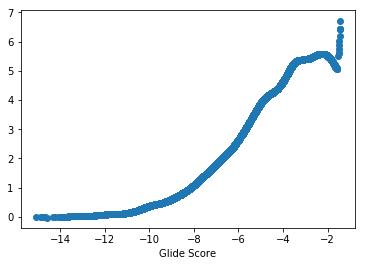

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


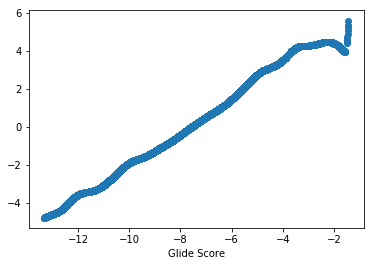

In [154]:
# Option 1: -logP(native | glide)
nlog_post = -np.log([pnative(gscore) for gscore in gscores])
plt.scatter(gscores, nlog_post)
plt.xlabel('- log P(N | G)')
plt.xlabel('Glide Score')
plt.show()

# Option 2: -logP(glide | native) + logP(glide | decoy)
single_pglide_like = np.array([likelihood(gscore) for gscore in gscores])
nlog_like = -np.log(single_pglide_like)
plt.scatter(gscores, nlog_like)
plt.xlabel('- log likelihood')
plt.xlabel('Glide Score')
plt.show()

# Sanity Check: Learned probabilities are well calibrated

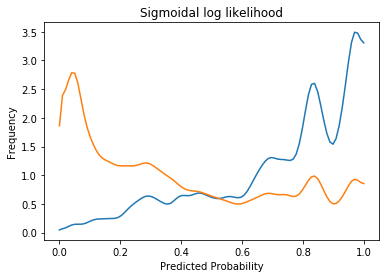

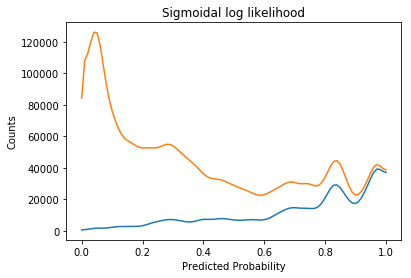

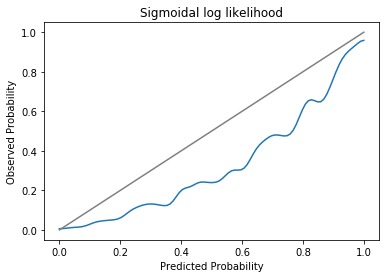

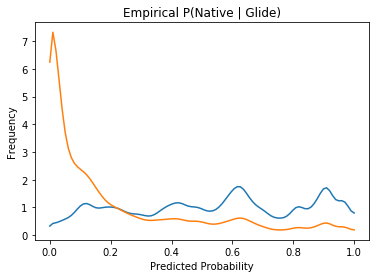

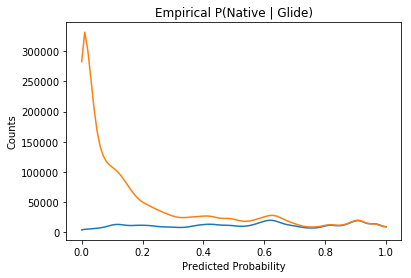

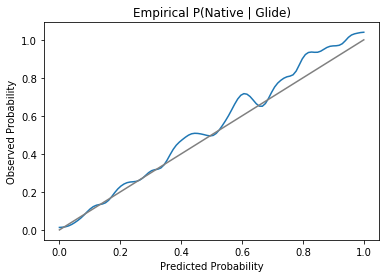

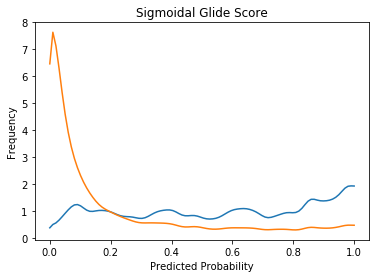

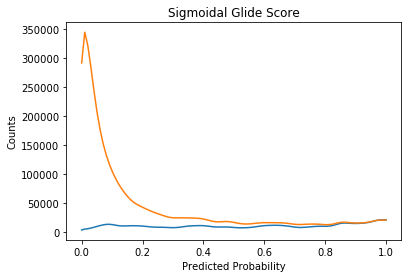

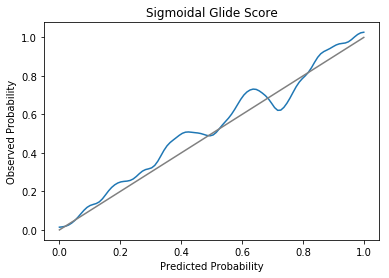

(<density_estimate.DensityEstimate instance at 0x1a30e94ab8>,
 <density_estimate.DensityEstimate instance at 0x1a302564d0>,
 <density_estimate.DensityEstimate instance at 0x1a302563f8>)

In [162]:
def check_calibration(truth, probs, title):
    native    = DensityEstimate(points=100, domain=(0, 1), reflect=True,
                                sd = 0.02, out_of_bounds=0).fit(probs[truth==1])
    reference = DensityEstimate(points=100, domain=(0, 1), reflect=True,
                                sd = 0.02, out_of_bounds=0).fit(probs)
    
    pnative = native.ratio(reference, prob = False)

    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel('Predicted Probability')
    plt.plot(native.x, native.fx)
    plt.plot(reference.x, reference.fx)
    plt.show()
    
    plt.title(title)
    plt.ylabel('Counts')
    plt.xlabel('Predicted Probability')
    plt.plot(native.x, native.fx*native.n_samples)
    plt.plot(reference.x, reference.fx*reference.n_samples)
    plt.show()

    plt.title(title)
    plt.ylabel('Observed Probability')
    plt.xlabel('Predicted Probability')
    plt.plot(pnative.x, pnative.fx)
    plt.plot([0, 1], [0, 1], c = 'gray')
    plt.show()
    return native, reference, pnative


l = np.array([likelihood(g) for g in gscores])

l[l == float('inf')] = np.max(l[l != float('inf')])

l = 1 / (1+np.exp(l))

check_calibration(natives, l,
                  'Sigmoidal log likelihood')

check_calibration(natives, np.array([pnative(g) for g in gscores]),
                  'Empirical P(Native | Glide)')

check_calibration(natives, 1 / (1 + np.exp(gscores+8.8)),
                  'Sigmoidal Glide Score')

# P(Native | Feature)

In [163]:
# Hydrogen Bond Donors
codes = [2]

scores = np.array([np.sum([score for (c, r), score in pose[-1].items()
                           if c in codes])
                   for protein, ligands in data.items()
                   for ligand, poses in ligands.items()
                   for rank, pose in poses.items()
                   if rank < max_poses])

## Unweighted

- In this case should choose interaction energy as $-\log P(N | X) + \log P(not N | X)$
- likelihood nearly identical to posterior

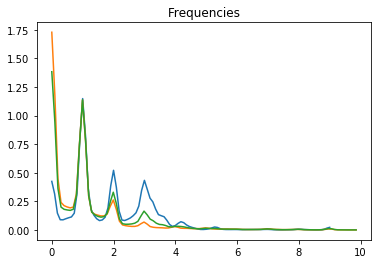

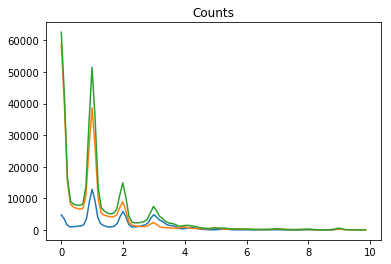

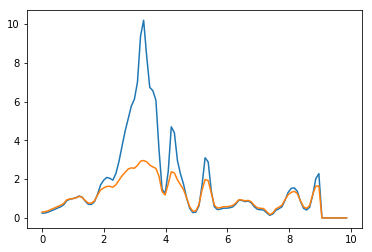

In [164]:
native_feat = DensityEstimate(points=100, reflect=False, sd = 0.1, out_of_bounds=0).fit(scores[natives==1])
decoy_feat = DensityEstimate(points=100, reflect=False, sd = 0.1, out_of_bounds=0).fit(scores[natives==0])
reference_feat = DensityEstimate(points=100, reflect=False, sd = 0.1, out_of_bounds=0).fit(scores)


plt.title('Frequencies')
plt.plot(native_feat.x, native_feat.fx)
plt.plot(decoy_feat.x, decoy_feat.fx)
plt.plot(reference_feat.x, reference_feat.fx)
plt.show()

plt.title('Counts')
plt.plot(native_feat.x, native_feat.fx*native_feat.n_samples)
plt.plot(decoy_feat.x, decoy_feat.fx*decoy_feat.n_samples)
plt.plot(reference_feat.x, reference_feat.fx*reference_feat.n_samples)
plt.show()

likelihood_feat = native_feat.ratio(decoy_feat, prob = True)
plt.plot(likelihood_feat.x, likelihood_feat.fx)

pnative_feat = native_feat.ratio(reference_feat, prob = True)
plt.plot(pnative_feat.x, pnative_feat.fx)
plt.show()

Glide 0.881926862289
Like 0.753542009645
Post 0.753536705685
Glide + Like 0.894077905566
Glide + Post 0.894771100451


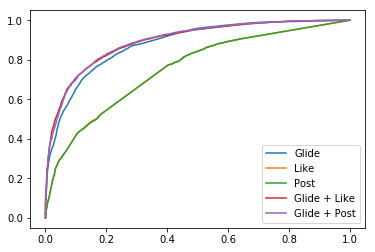

In [175]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_auc(truth, pred, label):
    fpr, tpr, thresh = roc_curve(truth, pred)
    plt.plot(fpr, tpr, label = label)
    print label, roc_auc_score(truth, pred)

l = np.array([likelihood_feat(score) for score in scores])
l[l == 0] = np.min(l[l!= 0])

p = np.array([pnative_feat(score) for score in scores])
p[p == 0] = np.min(p[p!= 0])
 
plot_auc(natives, -gscores, 'Glide')
plot_auc(natives, l, 'Like')
plot_auc(natives, p, 'Post')
plot_auc(natives, -gscores+np.log(l), 'Glide + Like')
plot_auc(natives, -gscores+np.log(p), 'Glide + Post')
plt.legend()
plt.show()

## Weighted by P(Native | Glide) (simple)

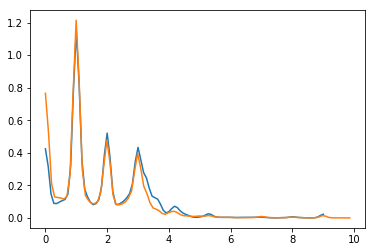

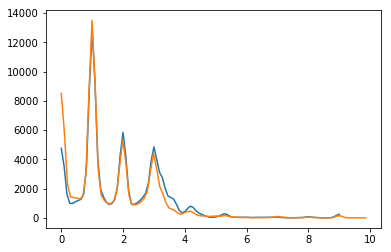

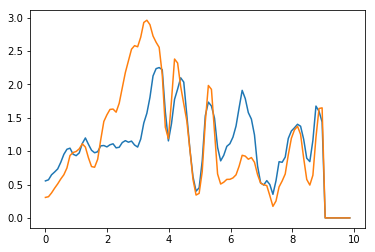

In [179]:
single_pglide = np.array([pnative(gscore) for gscore in gscores])

reference_feat_w = DensityEstimate(points=100, reflect=False, sd = 0.1, out_of_bounds=0
                              ).fit(scores, single_pglide)

plt.plot(native_feat.x, native_feat.fx)
plt.plot(reference_feat_w.x, reference_feat_w.fx)
plt.show()

plt.plot(native_feat.x, native_feat.fx*native_feat.n_samples)
plt.plot(reference_feat_w.x, reference_feat_w.fx*reference_feat_w.n_samples)
plt.show()


pnative_feat_w = native_feat.ratio(reference_feat_w, prob = True)
plt.plot(pnative_feat_w.x, pnative_feat_w.fx)
plt.plot(pnative_feat.x, pnative_feat.fx)
plt.show()

Glide 0.881926862289
max like 0.737238140855
max like + glide 0.897573215477
Post 0.727597075703
Glide + Post 0.893521288316


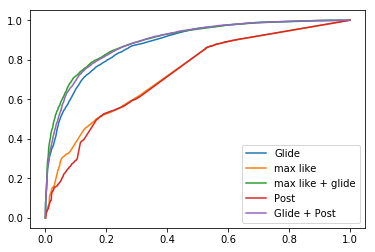

In [269]:
p = np.array([pnative_feat_w(score) for score in scores])
p[p == 0] = np.min(p[p!= 0])
 
b = DensityEstimate()
b.x = S
b.fx = np.array(B)
m = np.array([b(score) for score in scores])
plot_auc(natives, -gscores, 'Glide')
plot_auc(natives, -m, 'max like')
plot_auc(natives, -gscores-m, 'max like + glide')
plot_auc(natives, p, 'Post')
plot_auc(natives, -gscores+np.log(p), 'Glide + Post')
plt.legend()
plt.show()

## Weighted by P(Native | Glide)

- Weight by value that optimizes combined likelihood
- Should be close but

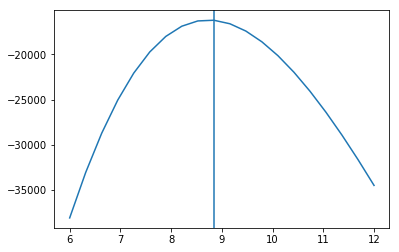

8.84210526316


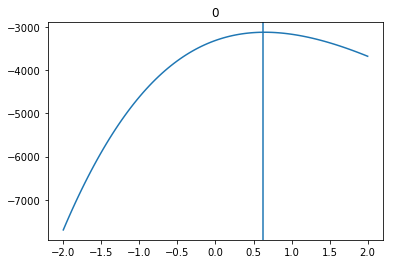

0.626262626263


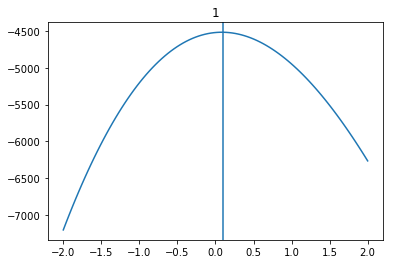

0.10101010101


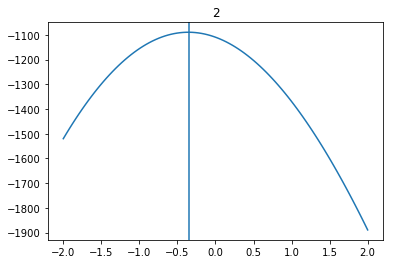

-0.343434343434


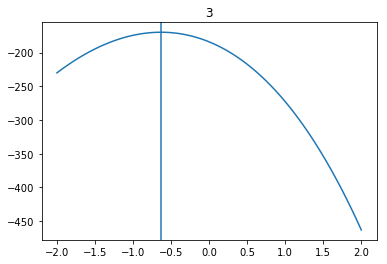

-0.626262626263


In [224]:
# Set C based on all data
def loss(Y, E):
    return np.sum(Y*-E - np.log(1 + np.exp(-E)))

x = np.linspace(6, 12, 20)
losses = np.array([loss(natives, gscores+C) for C in x])
C = x[np.argmax(losses)]
plt.plot(x, losses)
plt.axvline(C)
plt.show()
print C

# Fit X specific term

for i in range(4):
    
    x = np.linspace(-2, 2, 100)
    losses = np.array([loss(natives[scores == i], gscores[scores == i]+C+B) for B in x])
    B = x[np.argmax(losses)]
    
    plt.plot(x, losses)
    plt.axvline(B)
    plt.title(str(i))
    
    plt.show()
    print B

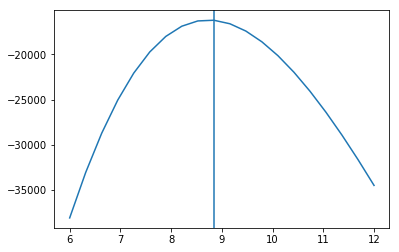

8.84210526316
0.45993741797
0.034669618339
-0.10839841923
-0.0638050864869


In [232]:
x = np.linspace(6, 12, 20)
losses = np.array([loss(natives, gscores+C) for C in x])
C = x[np.argmax(losses)]
plt.plot(x, losses)
plt.axvline(C)
plt.show()
print C

# Fit X specific term
for i in range(4):
    B = (np.log(np.sum(natives[scores == i]))
         - np.log(np.sum(np.exp(-(C+gscores[scores == i])) / (1 + np.exp(-(C+gscores[scores == i]))))))
    print -B

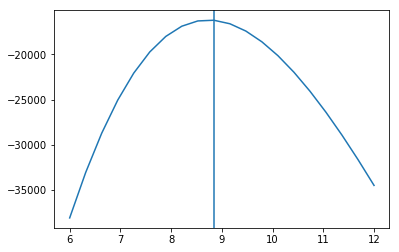

8.84210526316
2.44404585874
0.992701776169
0.215229642338
-0.969278702561


In [233]:
x = np.linspace(6, 12, 20)
losses = np.array([loss(natives, gscores+C) for C in x])
C = x[np.argmax(losses)]
plt.plot(x, losses)
plt.axvline(C)
plt.show()
print C

# Fit X specific term
for i in range(4):
    B = (np.log(np.sum(natives[scores == i]))
         - np.log(np.sum(1 - natives[scores == i])))
    print -B

# Now do fit with density estimate

- Is there a difference in how outputs from such a model could be combined for different datasets?

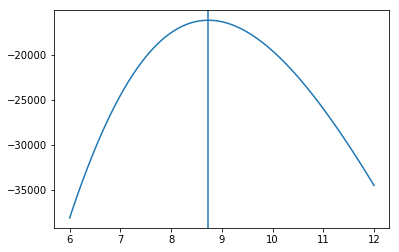

8.72727272727


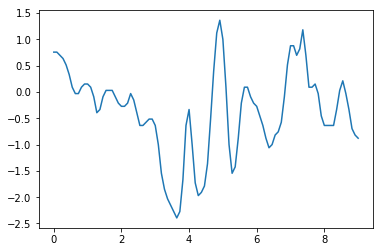

In [265]:
def loss(Y, E, W):
    return np.sum(W*(Y*-E - np.log(1 + np.exp(-E))))

def gauss(x, mean, stddev):
    return np.exp(-.5*((x-mean)/stddev)**2)

# plt.plot(np.linspace(-4, 4, 100), gauss(np.linspace(-4, 4, 100), 0, 1))
# plt.show()

# 1. Fit global constant
x = np.linspace(6, 12, 100)
losses = np.array([loss(natives, gscores+C, 1) for C in x])
C = x[np.argmax(losses)]
plt.plot(x, losses)
plt.axvline(C)
plt.show()
print C

# 2. Fit local constant at each point using local data
S = np.linspace(0, 9, 100)
X = np.linspace(-3, 3, 100)
B = []
for s in S:
    W = gauss(scores, s, 0.1)
    losses = np.array([loss(natives, gscores+C+x, W) for x in X])
    B += [X[np.argmax(losses)]]
plt.plot(S, B)

# Estimate with compact kernel using kNN bandwidth

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


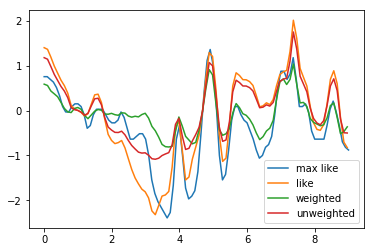

In [266]:
plt.plot(S, np.array(B), label = 'max like')
plt.plot(likelihood_feat.x, -np.log(likelihood_feat.fx), label = 'like')
plt.plot(pnative_feat_w.x, -np.log(pnative_feat_w.fx), label = 'weighted')
plt.plot(pnative_feat.x, -np.log(pnative_feat.fx), label = 'unweighted')
plt.legend()
plt.show()

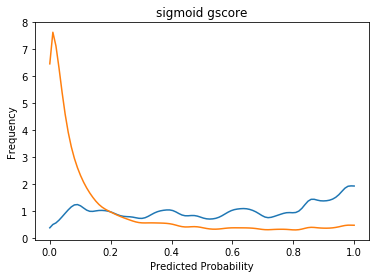

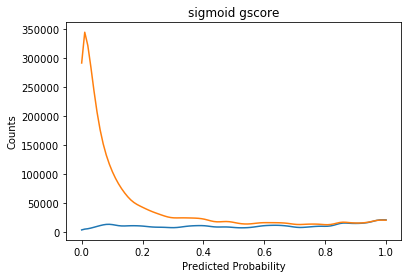

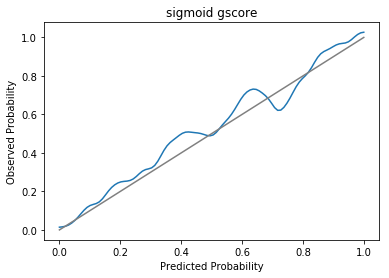

(<density_estimate.DensityEstimate instance at 0x1a3072a0e0>,
 <density_estimate.DensityEstimate instance at 0x12d6123b0>,
 <density_estimate.DensityEstimate instance at 0x12d6120e0>)

In [109]:
check_calibration(natives, np.exp(-gscores - 8.8) / (1+np.exp(-gscores - 8.8)), 'sigmoid gscore')

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


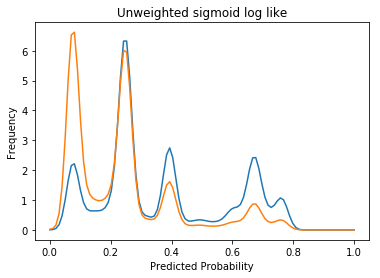

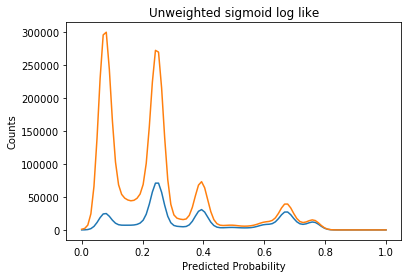

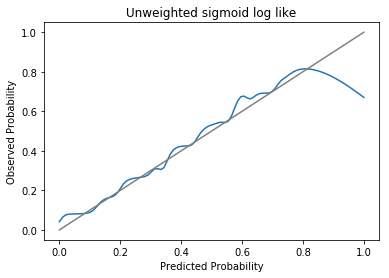

(<density_estimate.DensityEstimate instance at 0x1a3072eb00>,
 <density_estimate.DensityEstimate instance at 0x12dcf3200>,
 <density_estimate.DensityEstimate instance at 0x1a30535ef0>)

In [107]:
log_like = np.log(likelihoods)
check_calibration(natives, np.exp(log_like) / (1+np.exp(log_like)), 'Unweighted sigmoid log like')

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


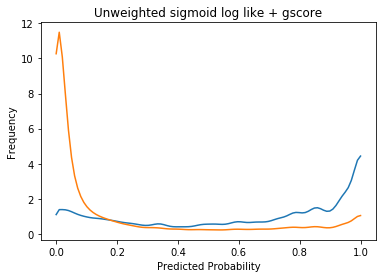

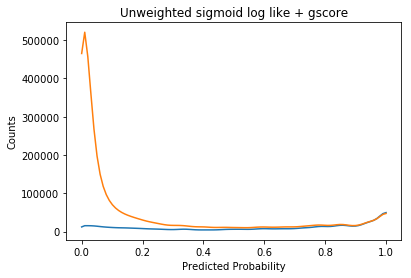

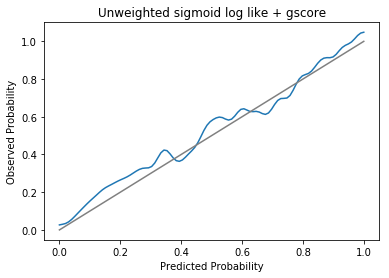

(<density_estimate.DensityEstimate instance at 0x1a3050c560>,
 <density_estimate.DensityEstimate instance at 0x1a308a5ab8>,
 <density_estimate.DensityEstimate instance at 0x1a3050c098>)

In [112]:
log_like = np.log(likelihoods)
check_calibration(natives,  np.exp(-gscores - 8.8 + log_like)
                  / (1+np.exp(-gscores - 8.8 + log_like)),
                  'Unweighted sigmoid log like + gscore')

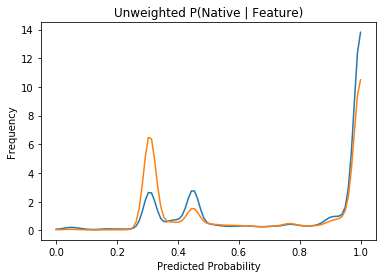

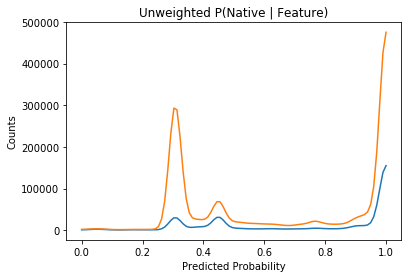

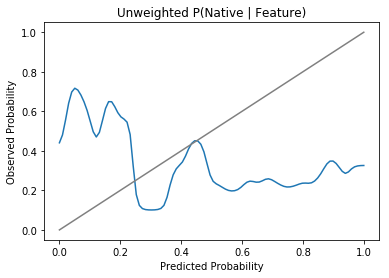

In [42]:
single_pfeat = np.array([pnative_feat(score) for score in scores])
check_calibration(natives, single_pfeat, 'Unweighted P(Native | Feature)')

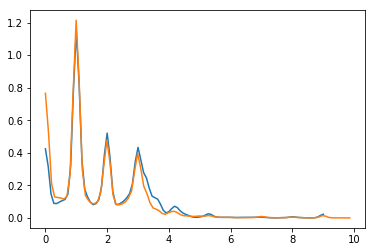

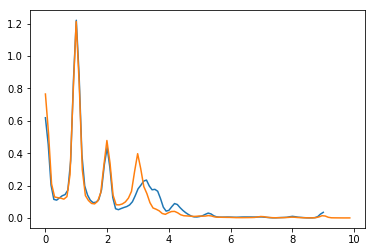

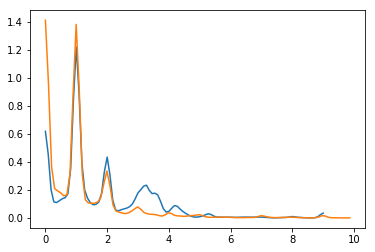

In [137]:
plt.plot(native_feat.x, native_feat.fx)
plt.plot(reference_feat_w.x, reference_feat_w.fx)
plt.show()

plt.plot(native_feat_w.x, native_feat_w.fx)
plt.plot(reference_feat_w.x, reference_feat_w.fx)
plt.show()

plt.plot(native_feat_w.x, native_feat_w.fx)
plt.plot(decoy_feat_w.x, decoy_feat_w.fx)
plt.show()

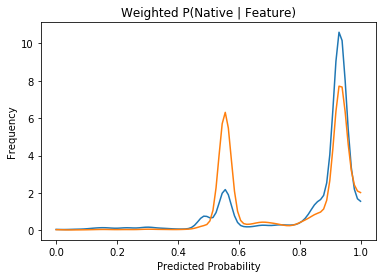

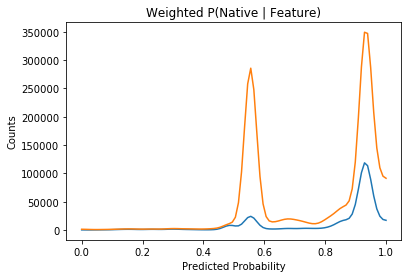

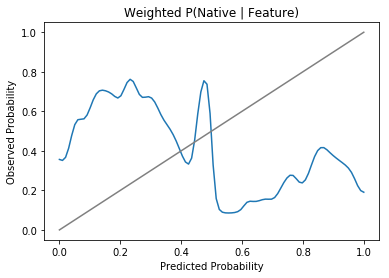

In [44]:
single_pfeat_w = np.array([pnative_feat_w(score) for score in scores])
check_calibration(natives, single_pfeat_w, 'Weighted P(Native | Feature)')

## Compare

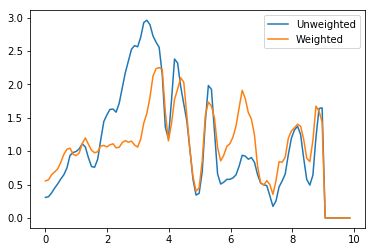

In [49]:
plt.plot(pnative_feat.x, pnative_feat.fx, label = 'Unweighted')
plt.plot(pnative_feat_w.x, pnative_feat_w.fx, label = 'Weighted')
plt.legend()
plt.show()

# Combining with Glide Score

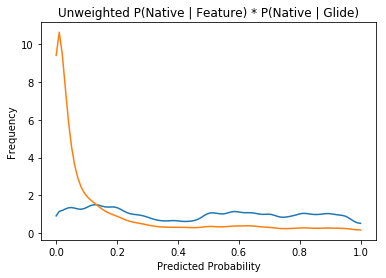

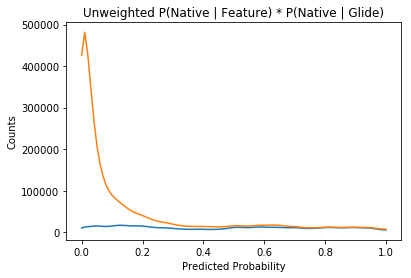

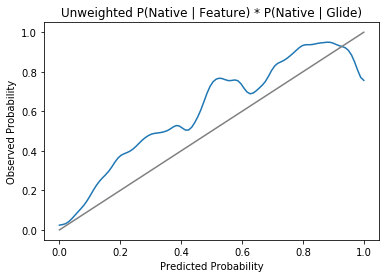

In [46]:
single_combind   = single_pfeat  * single_pglide

check_calibration(natives, single_combind, 'Unweighted P(Native | Feature) * P(Native | Glide)')

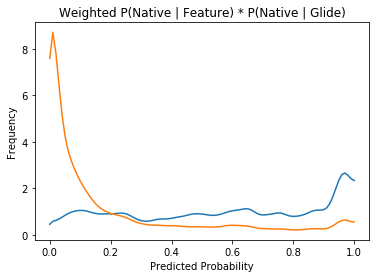

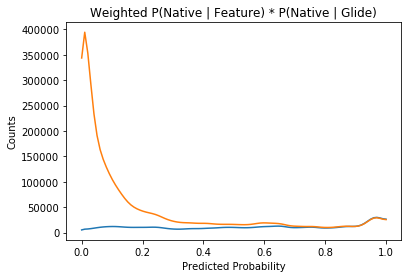

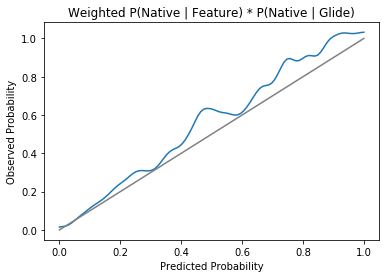

In [47]:
single_combind_w = single_pfeat_w * single_pglide
check_calibration(natives, single_combind_w, 'Weighted P(Native | Feature) * P(Native | Glide)')

# Check Calibration as energy term

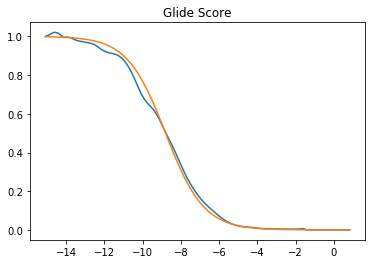

In [62]:
C_glide = 8.8
plt.title('Glide Score')
plt.plot(pnative.x, pnative.fx)
plt.plot(pnative.x, 1 / (1 + np.exp(pnative.x + 8.8)))
plt.show()

# Classification Accuracy

In [130]:
likelihood_w = native_feat_w.ratio(decoy_feat_w)

log_like_w = np.log(np.array([likelihood_w(score) for score in scores]))

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


Glide 0.881925681011
Unweighted 0.894040157083
Weighted 0.897324513428
Unweighted ComBind 0.893941406508
Weighted ComBind 0.897647643792


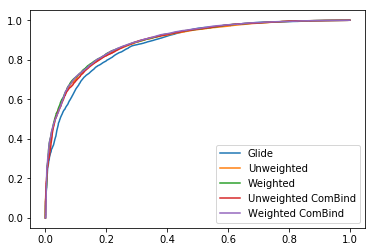

In [131]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_auc(truth, pred, label):
    fpr, tpr, thresh = roc_curve(truth, pred)
    plt.plot(fpr, tpr, label = label)
    print label, roc_auc_score(truth, pred)
    
    
log_like[np.isinf(log_like)] = 0
log_like_w[np.isinf(log_like_w)] = 0
    
plot_auc(natives, single_pglide, 'Glide')
plot_auc(natives, -gscores+log_like, 'Unweighted')
plot_auc(natives, -gscores+log_like_w, 'Weighted')
plot_auc(natives, single_combind, 'Unweighted ComBind')
plot_auc(natives, single_combind_w, 'Weighted ComBind')
plt.legend()
plt.show()

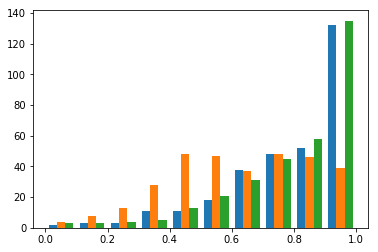

0.793773159828 0.624442132072 0.803428404372


In [83]:
# Average for all ligands
# Show that can differentiates poses of the same ligand

glide_roc, feat_roc, combind_roc = [], [], []
for protein, ligands in data.items():
    for ligand, poses in ligands.items():
        gscores = np.array([pose[0]
                            for rank, pose in poses.items()
                            if rank < max_poses])
        natives = np.array([pose[2] <= 2
                            for rank, pose in poses.items()
                            if rank < max_poses])
        scores = np.array([np.sum([score for (c, r), score in pose[-1].items()
                           if c in codes])
                           for rank, pose in poses.items()
                           if rank < max_poses])
        
        if not np.sum(natives): continue
        if not np.sum(natives == 0): continue
            
        single_pglide = np.array([pnative(gscore) for gscore in gscores])
        single_feat   = np.array([pnative_feat(score) for score in scores])
        single_feat_w   = np.array([pnative_feat_w(score) for score in scores])
        
        glide_roc    += [roc_auc_score(natives, single_pglide)]
        feat_roc     += [roc_auc_score(natives, single_feat_w)]
        combind_roc  += [roc_auc_score(natives, single_feat_w*single_pglide)]
        
plt.hist([glide_roc, feat_roc, combind_roc])
plt.show()

print np.mean(glide_roc), np.mean(feat_roc), np.mean(combind_roc)

# Get pair likelihoods and scores

In [26]:
def overlap(pose1, pose2, codes):
    return sum(np.sqrt(score1*pose2[-1][(c, r)])
               for (c, r), score1 in pose1[-1].items()
               if c in codes and (c, r) in pose2[-1])

def get_norm(poses1, poses2, codes):
    norm = 0
    for rank1, pose1 in poses1.items():
        if rank1 >= max_poses: continue
        for rank2, pose2 in poses2.items():
            if rank2 >= max_poses: continue
            norm = max(norm, overlap(pose1, pose2, codes))
    return norm



max_poses = 10

native, scores, pglide = [], [], []
for protein, ligands in data.items():
    for i, (ligand1, poses1) in enumerate(ligands.items()[:5]):
        for ligand2, poses2 in ligands.items()[i+1:5]:
            norm = get_norm(poses1, poses2, codes)
            for rank1, pose1 in poses1.items():
                if rank1 >= max_poses: continue
                for rank2, pose2 in poses2.items():
                    if rank2 >= max_poses: continue
                    native += [(pose1[2] <= 2) * (pose2[2] <= 2)]
                    scores += [overlap(pose1, pose2, codes) / norm if norm else 0]
                    pglide += [  pnative(pose1[0])
                               * pnative(pose2[0])]
native, scores, pglide = np.array(native), np.array(scores), np.array(pglide)

# Probability pair correct as function of product of pair likelihoods

In [27]:
native_pairs_pglide    = DensityEstimate(points=100, domain=(0, 1), reflect=True, sd = 0.02, out_of_bounds=0).fit(pglide[native==1])
reference_pairs_pglide = DensityEstimate(points=100, domain=(0, 1), reflect=True, sd = 0.02, out_of_bounds=0).fit(pglide)

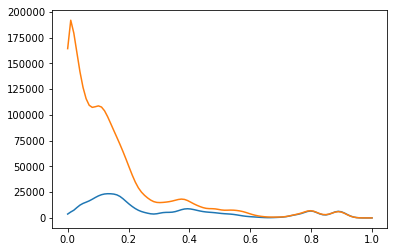

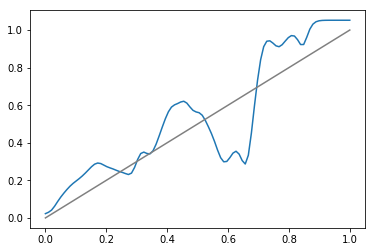

In [28]:
plt.plot(native_pairs_pglide.x, native_pairs_pglide.fx*native_pairs_pglide.n_samples)
plt.plot(reference_pairs_pglide.x, reference_pairs_pglide.fx*reference_pairs_pglide.n_samples)
plt.show()

pnative_pairs = native_pairs_pglide.ratio(reference_pairs_pglide, prob = False)
plt.plot(pnative_pairs.x, pnative_pairs.fx)
plt.plot([0, 1], [0, 1], c = 'gray')
plt.show()
plt.show()

# Unweighted Feature Distributions

In [29]:
native_pairs_scores    = DensityEstimate(points=100, domain=(0, 1), reflect=True, sd = 0.02, out_of_bounds=0).fit(scores[native==1])
reference_pairs_scores = DensityEstimate(points=100, domain=(0, 1), reflect=True, sd = 0.02, out_of_bounds=0).fit(scores)

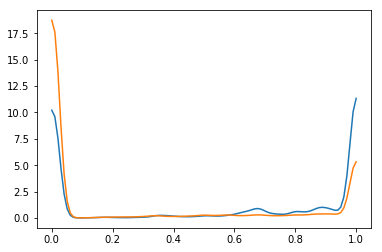

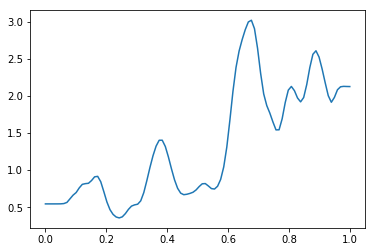

In [30]:
plt.plot(native_pairs_scores.x, native_pairs_scores.fx)
plt.plot(reference_pairs_scores.x, reference_pairs_scores.fx)
plt.show()

score_ratio = native_pairs_scores.ratio(reference_pairs_scores, prob = True)
plt.plot(score_ratio.x, score_ratio.fx)
plt.show()

# Weighted Feature Distributions

In [31]:
reference_pairs_weighted = DensityEstimate(points=100, domain=(0, 1), reflect=True, sd = 0.02, out_of_bounds=0).fit(scores,  pglide)

KeyboardInterrupt: 

In [ ]:
plt.plot(native_pairs_scores.x, native_pairs_scores.fx)
plt.plot(reference_pairs_scores.x, reference_pairs_weighted.fx)
plt.show()

weighted_ratio = native_pairs_scores.ratio(reference_pairs_weighted, prob = True)
plt.plot(weighted_ratio.x, weighted_ratio.fx)
plt.plot(score_ratio.x, score_ratio.fx)
plt.show()

# ComBind Scores

In [32]:
pairwise = np.array([score_ratio(s) for s in scores])
combind = pairwise*pglide
# pairwise_weighted = np.array([weighted_ratio(s) for s in scores])
# combind_weighted = pairwise_weighted*pglide

In [ ]:
native_pairs_combind    = DensityEstimate(points=100, domain=(0, 1), reflect=True, sd = 0.02, out_of_bounds=0).fit(combind[native==1])
reference_pairs_combind = DensityEstimate(points=100, domain=(0, 1), reflect=True, sd = 0.02, out_of_bounds=0).fit(combind)

In [ ]:
native_pairs_combind_weighted    = DensityEstimate(points=100, domain=(0, 1), reflect=True, sd = 0.02, out_of_bounds=0).fit(combind_weighted[native==1])
reference_pairs_combind_weighted = DensityEstimate(points=100, domain=(0, 1), reflect=True, sd = 0.02, out_of_bounds=0).fit(combind_weighted)

In [ ]:
plt.plot(native_pairs_combind.x, native_pairs_combind.fx*native_pairs_combind.n_samples)
plt.plot(reference_pairs_combind.x, reference_pairs_combind.fx*reference_pairs_combind.n_samples)
plt.show()

plt.plot(native_pairs_combind_weighted.x, native_pairs_combind_weighted.fx*native_pairs_combind_weighted.n_samples)
plt.plot(reference_pairs_combind_weighted.x, reference_pairs_combind_weighted.fx*reference_pairs_combind_weighted.n_samples)
plt.show()

ratio = native_pairs_combind.ratio(reference_pairs_combind, prob = False)
plt.plot(ratio.x, ratio.fx)

ratio = native_pairs_combind_weighted.ratio(reference_pairs_combind_weighted, prob = False)
plt.plot(ratio.x, ratio.fx)

plt.plot([0, 1], [0, 1], c = 'gray')
plt.show()

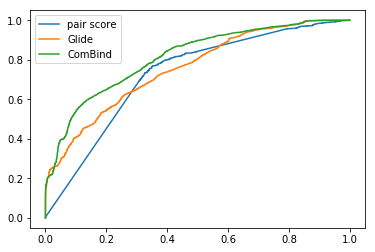

In [33]:
from sklearn.metrics import roc_curve

tpr, fpr, thresh = roc_curve(native, -pairwise, pos_label = 1)
plt.plot(fpr, tpr, label = 'pair score')

# tpr, fpr, thresh = roc_curve(native, -pairwise_weighted, pos_label = 1)
# plt.plot(fpr, tpr, label = 'weighted pair score')


tpr, fpr, thresh = roc_curve(native, -pglide, pos_label = 1)
plt.plot(fpr, tpr, label = 'Glide')



tpr, fpr, thresh = roc_curve(native, -combind, pos_label = 1)
plt.plot(fpr, tpr, label = 'ComBind')

# tpr, fpr, thresh = roc_curve(native, -combind_weighted, pos_label = 1)
# plt.plot(fpr, tpr, label = 'weighted ComBind')
plt.legend()
plt.show()